In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from formulaic import Formula
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import seaborn.objects as so
from sklearn.metrics import mean_squared_error
from time import time
import logging
from sklearn.metrics import r2_score
import os

# Estas dos lineas son para silenciar las advertencias de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
import keras

from tf_regressor import train_test_split_scale_center, Regressor

/home/matias/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Ej 1: Coronavirus

### a) Cargar dataset y anñadirle nueva columna

In [2]:
data = pd.read_csv('dataset/casos_coronavirus.csv')
data.dropna(inplace=True)

In [3]:
data.head(3)

,fecha,confirmados_Nuevos
0,3-3-2020,1
1,4-3-2020,0
2,5-3-2020,1


In [4]:
# Añado la columna "dias_transcurridos" 
data["dias_transcurridos"] = data.index + 1
data

,fecha,confirmados_Nuevos,dias_transcurridos
0,3-3-2020,1,1
1,4-3-2020,0,2
2,5-3-2020,1,3
3,6-3-2020,6,4
4,7-3-2020,0,5
...,...,...,...
91,2-6-2020,904,92
92,3-6-2020,949,93
93,4-6-2020,929,94
94,5-6-2020,840,95


### b) Plotear dias_transcurridos vs confirmados_nuevos

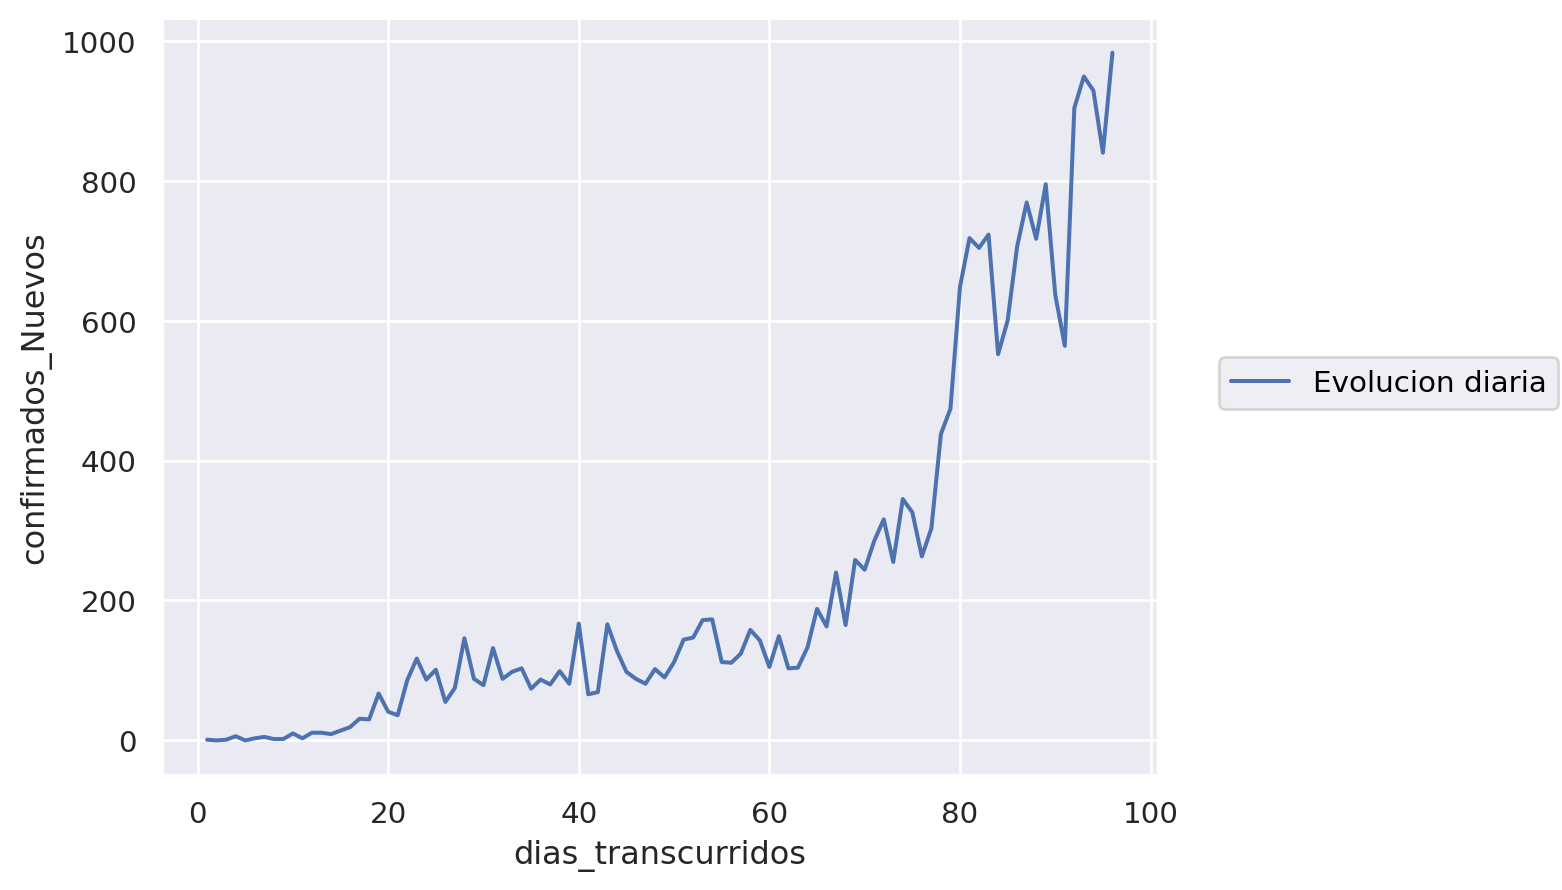

In [5]:
(
    so.Plot()
    .add(so.Line(), x = data["dias_transcurridos"], y = data["confirmados_Nuevos"], label = "Evolucion diaria")
)

 ### c) Armar modelo de regresion que permita explicar la evolucion de casos de coronavirus (Y) en funcion de los dias transcurridos (X).

 Para esto se proponen los siguientes modelos que no voy a copiar 

In [6]:
# Me pinto hacerlo con Linear Regression

# Dividimos el conj de datos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split_scale_center(data["dias_transcurridos"], data["confirmados_Nuevos"], test_size=0.2, random_state=42)

modelo = linear_model.LinearRegression()
modelo.fit(X_train.to_frame(), y_train.to_frame())
y_pred = modelo.predict(X_test.to_frame())
sqecm = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("raiz de ECM: ", sqecm)
print("R2 ", r2)

raiz de ECM:  127.8344462288248
R2  0.7632864376587793


#### i) Cuadrados Minimos


$$Y = b +  w_{0} X + w_{1}X^{2} $$

In [7]:
# Spliteamos y escalamos nuestro dataset.
X_train, X_test, y_train, y_test = train_test_split_scale_center(data["dias_transcurridos"], data["confirmados_Nuevos"], test_size=0.2, random_state=42)

# Generamos un modelo de Cuadrados Minimos de orden 2
polinomial_features = PolynomialFeatures(degree = 2, include_bias = False)
X_train_poly = polinomial_features.fit_transform(X_train.values.reshape(-1, 1))
X_test_poly = polinomial_features.fit_transform(X_test.values.reshape(-1, 1))

modelo = linear_model.LinearRegression()
modelo.fit(X_train_poly, y_train)

y_pred = modelo.predict(X_test_poly)

sqecm = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("sq ECM: ", sqecm)
print("R²: ", r2)

sq ECM:  91.80278618829435
R²:  0.8779215303028765


In [10]:
o_origen = modelo.intercept_.item()
beta = modelo.coef_
print('beta_0: ', o_origen)
print('beta_1: ', beta[0])
print('beta_2: ', beta[1])

beta_0:  92.79495993114168
beta_1:  761.0218822462997
beta_2:  1558.6820957981788


Luego, obtenemos que:

$$Y = b +  w_{0} X + w_{1}X^{2} $$

Se escribe así:

$$Y = 92.79 +  761 X + 1558X^{2} $$

In [33]:
beta

array([ 255.56138833, 1568.57537969, 3226.59345719])

#### ii) MLM

$$Y = b + w_{0}X^{w_{1}} $$

## Ej 2: Titanic

### al) Limpiando el dataset

In [30]:
titanic = sns.load_dataset("titanic")

In [31]:
# Contamos la cantidad de nulls
titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [32]:
# En base a lo anterior decidimos dropear "deck" y "age"
titanic = titanic.drop("deck", axis = 1).drop("age", axis = 1)
titanic.isnull().sum()

survived       0
pclass         0
sex            0
sibsp          0
parch          0
fare           0
embarked       2
class          0
who            0
adult_male     0
embark_town    2
alive          0
alone          0
dtype: int64

<Axes: xlabel='fare'>

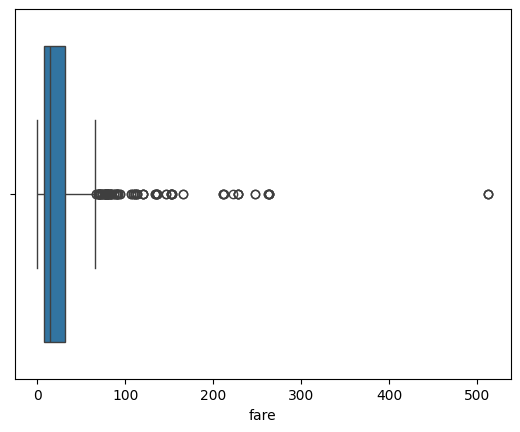

In [35]:
# Graficamos un boxplot de "fare" (precio del boleto)

sns.boxplot(titanic, x = "fare")

Observamos muchisimos outliers en fare. 

In [46]:
# Exploramos el metodo de pandas "quantile" para calcular el cuantil 0.99 de la columna fare
# Y utilizarlo para eliminar las observaciones con outliers en esa columna
print("El percentil 99 del precio del boleto es:",titanic["fare"].quantile(0.99))

El percentil 99 del precio del boleto es: 249.00622000000035


El percentil 99 es el valor por debajo del cual se encuentra el 99% de los datos. Esto significa que el 99% de los valores en la columna "fare" son menores o iguales a este valor, y solo el 1% de los valores son mayores que este.

Entonces, si quisieramos eliminar nuestros outliers del cuantil 99%, podriamos ayudarnos de este siguiente codigo:

In [50]:
titanic_sin_outliers = titanic[titanic["fare"] <= titanic["fare"].quantile(0.99)]
titanic_sin_outliers["fare"].quantile(0.99)

211.3375

### b) Realizar regresión logística para predecir la variable binaria de supervivencia (survived) a partir del precio del boleto (fare). 

¿Qué porcentaje de casos clasifica correctamente?

In [ ]:
# 